In [1]:
%load_ext autoreload
%autoreload 2

### Import block
I still need to figure out how to get things to auto-reload, but that's a future project.

In [2]:
# Import section
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mdwtools import mdwfunctions as mwfn
from mdwtools import mdwplots as mwp

import cesm1to2plotter as c1to2p

import os

### Load Section
This section is where we set all of the flags and load options

In [3]:
# Set flags/options section
diff_flag = False
loadCeres_flag = True
loadErai_flag = True  # True to load ERAI fields
loadGpcp_flag = True
loadHadIsst_flag = True
mp_flag = False  # True to use multiprocessing when regridding
newRuns_flag = False
obs_flag = False
ocnOnly_flag = True  # Need to implement to confirm CTindex is right.
regridVertical_flag = False
regrid2file_flag = True
regridOverwrite_flag = True
reload_flag = False
save_flag = False
saveDir = c1to2p.setfilepaths()[2]
saveSubDir = ''  # 'testfigs/66to125/'
saveThenClose_flag = True
verbose_flag = False

fns_flag = True
fnt_flag = True
lts_flag = False
prect_flag = True

#### This is where we load the model runs

In [4]:
# Load data section
# Set name(s) of file(s) to load
versionIds = ['01', '28', '36',
              'ga7.66',
              # '100',
              # '113',
              # '114',
              # '116',
              # '118',
              '119',
              # '119f',
              # '119f_gamma', '119f_ice', '119f_liqss', '119f_microp',
              # '119f_nocwv',
              '125',
              # '125f',
              '161', '194', '195',
              '297',
              # '297_nocwv',
              # '297f',
              # '297f_microp',
              # '297f_sp',
              # '297f_pra',
              ]

# Set levels for vertically regridding
newLevs = np.array([100, 200, 275, 350, 425,
                    500, 550, 600, 650, 700,
                    750, 800, 850, 900, 950,
                    975, 1000
                    ])

# Set variables to regrid vertically
#   Number of variables I can load is very memory dependent.
regridVars = ['V', 'OMEGA', 'RELHUM', 'CLOUD', 'T', 'U',
              'AREI', 'AREL', 'AWNC', 'AWNI',
              'CLDICE', 'CLDLIQ',
              # 'ICIMR', 'ICWMR',
              ]

# Get directory of file to load
ncDir, ncSubDir, saveDir2 = c1to2p.setfilepaths(
    loadClimo_flag=True,
    newRuns_flag=newRuns_flag,
    )

if saveDir is None:
    saveDir = saveDir2

# Redefine ncSubDir for certain cases if desired
# ncSubDir1 = ncSubDir
# ncSubDir = {vid: ncSubDir1 for vid in versionIds}
# ncSubDir['119'] = 'yrs_21-40/'
# ncSubDir['ga7.66'] = 'yrs_55-74/'

# Load (or reload) datasets from file and regrid if requested/needed
dataSets, dataSets_rg = c1to2p.loadmodelruns(
    versionIds,
    loadClimo_flag=True,
    lts_flag=lts_flag,
    mp_flag=mp_flag,
    ncDir=ncDir,
    ncSubDir=ncSubDir,
    newLevs=newLevs,
    regrid2file_flag=regrid2file_flag,
    regridOverwrite_flag=regridOverwrite_flag,
    regridVars=regridVars,
    regridVertical_flag=regridVertical_flag,
    )

# Print done block
print('---------------\n' +
      '| Runs loaded |\n' +
      '---------------')

---------------
| Runs loaded |
---------------


#### Load observational datasets for comparison

In [5]:
# Load dictionary of observational datasets
obsDsDict = c1to2p.loadobsdatasets(
    obsList=None,
    ceresEbaf_flag=loadCeres_flag,
    erai_flag=loadErai_flag,
    gpcp_flag=(loadGpcp_flag or plotGpcpTest_flag),
    gpcpYrs=[1979, 2009],
    hadIsst_flag=loadHadIsst_flag,
    hadIsstYrs=[1979, 2005],
    whichGpcp='all',
    whichHad='all',
    )

# Print done block
print('--------------\n' +
      '| Obs loaded |\n' +
      '--------------')

--------------
| Obs loaded |
--------------


#### Check that all cases loaded

In [6]:
print(dataSets.keys())
try:
    print(obsDsDict.keys())
except NameError:
    print('No obs loaded.')

dict_keys(['01', '28', '36', 'ga7.66', '119', '125', '161', '194', '195', '297'])
dict_keys(['ceresClimo', 'eraiClimo', 'gpcp', 'gpcpClimo', 'hadIsst', 'hadIsstClimo'])


### Plotting section
#### Plot multiple maps on one figure for easy comparison

In [ ]:
save_flag = True

# Set plotting options
plotIdList = [
    # '119f_nocwv', '297_nocwv',
    # '119f', '297',
    '125f',
    # ('119f_microp' if '119f_microp' in dataSets.keys() else None),
    ('119f_gamma' if '119f_gamma' in dataSets.keys() else None),
    # None, None, None, None, None, None,
     '119f_nocwv',
    # '119f_ice',
    '119f_liqss',
    '297f', None,  # 'obs',
    # '01',
    # '28', '36', 'ga7.66',
    # '119', '125', '161',
    # '194', '195', '297', # None, None # 'obs'
    # '297f', '297f_sp', '297f_sp',
    ]
plotVars = ['PRECT']  # , 'CLDLOW', 'FSNS', 'SWCF']  # , 'TS', 'CLDLOW', 'FSNS', 'SWCF']
#        'CDNUMC']  # , 'SWCF', 'PBLH']
plevs = [500]
box_flag = False
boxLat = np.array([-30, 30])
boxLon = np.array([240, 270])
compcont_flag = False
diff_flag = True
useDiffDs_flag = False  # Will plot all color contours from Diff list rather than plot list
#                       # useful for climo with differences in line contours.
diffDs = None  # obsDsDict['ceresClimo']  # dataSets_rg
diffDsDict = None
diffAsPct_flag = True
diffIdList = ['119f']*len(plotIdList)
    # '119f', '119f', '297f']
    # None,  # ['119f']*len(plotIdList)
    # ,  # '119f', '297',
    # '119f']*len(plotIdList)
    # ['119f', '119f', '119f',
    # '119f', '119f', '119f',
    # '119f', None, None,
    # '119', '119f', None,
    # '119f', '119f', '119f',
    # ]
diffVar = None
diffPlevs = plevs
levels = None  # np.arange(-50.0, 50.01, 5.)

lineCont_flag = True
lineContDiff_flag = True
lineContDiffAsPct_flag = False
lineContVar = 'CLDLOW'

quiver_flag = False
uVar = 'TAUX'
vVar = 'TAUY'

tSteps = np.arange(0, 12)

threeDVars = dataSets_rg[plotIdList[0]]

for plotVar in plotVars:
    for jlev, plev in (enumerate(plevs) if plotVar in threeDVars else enumerate([1000])):
        if diffVar is None:
            diffVar = plotVar
        c1to2p.plotmultilatlon((dataSets_rg
                                if plotVar
                                in dataSets_rg[plotIdList[0]]
                                else dataSets),
                               plotIdList,
                               plotVar,
                               box_flag=box_flag,
                               boxLat=boxLat,
                               boxLon=boxLon,
                               cbar_flag=True,
                               cbarOrientation='vertical',
                               # cMap='Blues',
                               compcont_flag=compcont_flag,
                               diff_flag=diff_flag,
                               diffAsPct_flag=diffAsPct_flag,
                               diffIdList=diffIdList,
                               diffDs=diffDs,
                               diffDsDict=(diffDsDict
                                           if diffDsDict is not None
                                           else (dataSets_rg
                                                 if plotVar in dataSets_rg[plotIdList[0]]
                                                 else dataSets)),
                               diffPlev=(diffPlevs[jlev]
                                         if plotVar in threeDVars
                                         else 1000),
                               diffVar=diffVar,
                               extend=None,
                               figSize=[10, 6.5],
                               fontSize=24,
                               latLim=np.array([-30.1, 30.1]),
                               latlbls=np.arange(-30, 30.1, 10),
                               levels=levels,
                               lineCont_flag=lineCont_flag,
                               lineContDiff_flag=lineContDiff_flag,
                               lineContDiffAsPct_flag=lineContDiffAsPct_flag,
                               lineContVar=lineContVar,
                               lineContDiffVar=lineContVar,
                               lineContUseDiffDs_flag=all([diff_flag,
                                                           not lineContDiff_flag]),
                               lineContLevels=np.concatenate([np.arange(-0.9, -0.001, 0.05),
                                                              np.arange(0.05, 0.9001, 0.05)]),
                               lonLim=np.array([99.5, 290.5]),
                               lonlbls=np.arange(120, 270.1, 30),
                               obsDs=obsDsDict['ceresClimo'],
                               ocnOnly_flag=False,
                               plev=plev,
                               quiver_flag=quiver_flag,
                               quiverNorm_flag=False,
                               quiverScale=(
                                   c1to2p.getquiverprops(
                                        uVar, vVar,
                                        diff_flag=diff_flag)['quiverScale']
                                   ),
                               quiverUnits='inches',
                               rmRegLatLim=np.array([-20, 20]),
                               rmRegLonLim=np.array([119.5, 270.5]),
                               rmRegMean_flag=False,
                               rmse_flag=False,
                               save_flag=save_flag,
                               saveDir=(saveDir +
                                        saveSubDir  # +
                                        # 'atm/maps/'
                                        ),
                               stampDate_flag=False,
                               subFigCountStart='a',
                               subSamp=7,
                               tSteps=tSteps,
                               useDiffDs_flag=useDiffDs_flag,
                               uRef=c1to2p.getquiverprops(
                                   uVar, vVar,
                                   diff_flag=diff_flag)['uRef'],
                               uVar=uVar,
                               vVar=vVar,
                               verbose_flag=False,
                               )
        if diffVar == plotVar:
            diffVar = None
print('done')
plt.show()

#### Plot multiple pressure-latitude plots on one figure for ease of comparison

In [ ]:
save_flag = False

# Set variable to plot with colored contours
colorVars = ['CLDICE', 'CLDLIQ']  # , 'AREL', 'CLDLIQ', 'CLDICE',
#             'T', 'RELHUM', 'CLOUD', 'OMEGA']
plotCases = [  # '125f', None, None,
             '125f', '119f_microp', '119f_gamma',
              '119f_nocwv', '119f_ice', '119f_liqss',
              '297f', None, None
             # '125', '125f', None,
             # '119f_microp', '119f_gamma', '119f_liqss'
             ]
diff_flag = True
lineCont_flag = False
lineContDiff_flag = False

diffIdList = ['119f', '119f', '119f',
              '119f', '119f', '119f',
              '119f', None, None,
              ]
diffCase = {'119f': '119f_microp',
            '119f_gamma': '119f',
            '119f_liqss': '119f',
            '119f_microp': '119f',
            '125': '119',
            '125f': '119f',
            'cesm20f': '119f',
            'cesm20f_microp': 'cesm20f',
            'cesm20f_sp': '119f',
            }

# Set variable to plot with black contours
contVar = None  # 'CLOUD'

quiver_flag = True
# save_flag = False

# Set plotting limits
latLim = np.array([-40, 40])
lonLim = np.array([240, 270])
pLim = np.array([1000, 200])
tLim = np.array([0, 12])  # exclusive of end pt.
dt = 1

# Loop through variables and plot them.
for colorVar in colorVars:
    c1to2p.plotmultipressurelat(
        dataSets_rg,
        plotCases,
        colorVar,
        # caseString=None,
        cbar_flag=True,
        # cbar_dy=-0.1,
        # cbar_height=0.02,
        # cMap=None,
        colorConts=None,  # np.arange(-5, 5.01, 0.5),
        # dCont_flag=False,
        # dContCase=None,
        diff_flag=diff_flag,
        diffIdList=([None if vid is None
                     else diffCase[vid]
                     for vid in plotCases]
                     if diffIdList is None
                     else diffIdList),
        dt=1,
        latLbls=np.arange(-30, 30.1, 10),
        latLim=latLim,
        latSubSamp=3,
        lonLim=lonLim,
        lineCont_flag=lineCont_flag,
        # lineContDiff_flag=lineContDiff_flag,
        # lineConts=None,
        # lineContVar=colorVar,
        # lineContDs=dataSets_rg,
        # lineContDiffIdList=None,
        pLim=pLim,
        quiver_flag=quiver_flag,
        # quiverScale=3,
        # quiverUnits='inches',
        save_flag=save_flag,
        saveDir=saveDir,
        saveSubDir='',  # atm/meridslices/',
        saveThenClose_flag=saveThenClose_flag,
        tLim=tLim,
        wScale=100,
        )
print('done')
plt.show()

#### Plot single metric as a function of model version

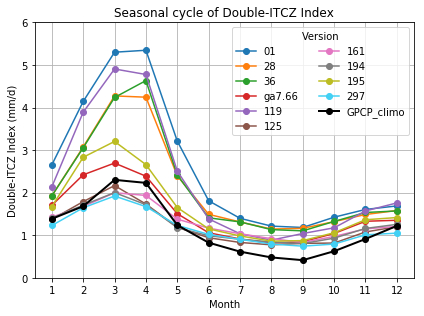

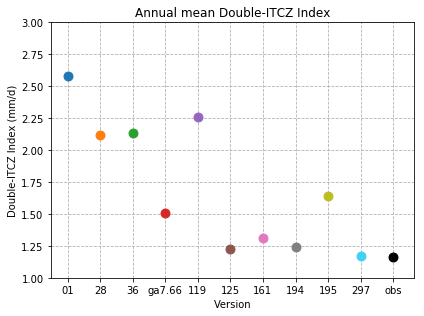

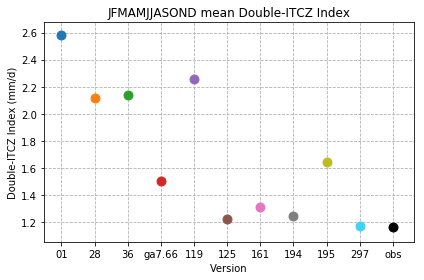

In [9]:
# Set name of index to plot
#   available: 'dITCZ', 'PAI', 'pcent', 'dpdy_epac', dsstdy_epac', 'fnsasym', 'sepsst'
indexName = 'dITCZ'

obsKey = 'gpcpClimo'
obsVar = 'precip'

save_flag = False

c1to2p.plotmetricvsversion(indexName,
                           dataSets,
                           makeFigure_flag=True,
                           obsDs=obsDsDict[obsKey],
                           obsVar=obsVar,
                           ocnOnly_flag=True,
                           plotAnnMean_flag=True,
                           plotPeriodMean_flag=True,
                           plotSeasCyc_flag=True,
                           plotObs_flag=True,
                           plotVar=None,
                           rmAnnMean_flag=False,
                           save_flag=save_flag,
                           saveDir=None,
                           tSteps=np.arange(0, 12),
                           versionIds=versionIds,
                           yLim_annMean=None,
                           yLim_periodMean=None,
                           yLim_seasCyc=None,
                           )
plt.show()

#### Plot multiple metrics as function of model version

In [18]:
import matplotlib.gridspec as gridspec  # pretty subplots

def plotmultimetricvsversion(
    indexNames,
    ds,
    dpi=300,
    figSize=None,
    indexTypes=None,
    obsDsDict=None,
    plotObs_flag=False,
    plotAnnMean_flag=False,
    plotPeriodMean_flag=False,
    plotSeasCyc_flag=False,
    save_flag=False,
    saveDir=None,
    subFigLblStart='a',
    **kwargs
    ):
    """
    Plot multiple metrics on one figure.
    Assumes only one of plotAnnMean_flag, plotPeriodMean_flag,
        and plotSeasCyc_flag will be True
    """
    
    # Set index Types to None by default
    if indexTypes is None:
        indexTypes = dict()

    # Create figure for plotting
    hf = plt.figure()
    
    # Set subplot details
    if plotSeasCyc_flag:
        if len(indexNames) == 2:
            if figSize is None:
                hf.set_size_inches(6, 4.5, forward=True)
            else:
                hf.set_size_inches(figSize[0],
                                   figSize[1],
                                   forward=True)

            gs = gridspec.GridSpec(2, 2,
                                   # height_ratios=[20, 1, 20, 1, 20],
                                   hspace=0.4,
                                   width_ratios=[5, 1],
                                   )
            gs.update(left=0.07, right=0.95, top=0.95, bottom=0.05)

            # Set gridpsec index order
            colInds = [0, 0]
            rowInds = [0, 1]
            
            # Set gridspec legend location
            legColInd = 1
            legRowInd = 0
        elif len(indexNames) == 4:
            if figSize is None:
                hf.set_size_inches(10, 4.5, forward=True)
            else:
                hf.set_size_inches(figSize[0],
                                   figSize[1],
                                   forward=True)

            gs = gridspec.GridSpec(2, 3,
                                   # height_ratios=[20, 1, 20, 1, 20],
                                   hspace=0.4,
                                   width_ratios=[7, 7, 1],
                                   wspace=0.4,
                                   )
            gs.update(left=0.07, right=0.95, top=0.95, bottom=0.05)

            # Set gridpsec index order
            colInds = [0, 1, 0, 1]
            rowInds = [0, 0, 1, 1]
            
            # Set gridspec legend location
            legColInd = 2
            legRowInd = 0

        elif len(indexNames) == 6:
            if figSize is None:
                hf.set_size_inches(10, 6.5, forward=True)
            else:
                hf.set_size_inches(figSize[0],
                                   figSize[1],
                                   forward=True)

            gs = gridspec.GridSpec(3, 3,
                                   # height_ratios=[20, 1, 20, 1, 20],
                                   hspace=0.45,
                                   width_ratios=[7, 7, 1],
                                   wspace=0.4,
                                   )
            gs.update(left=0.07, right=0.95, top=0.95, bottom=0.05)

            # Set gridpsec index order
            colInds = [0, 1, 0, 1, 0, 1]
            rowInds = [0, 0, 1, 1, 2, 2]
            
            # Set gridspec legend location
            legColInd = 2
            legRowInd = 0
    else:
        if len(indexNames) == 2:
            if figSize is None:
                hf.set_size_inches(6, 4.5, forward=True)
            else:
                hf.set_size_inches(figSize[0],
                                   figSize[1],
                                   forward=True)

            gs = gridspec.GridSpec(2, 1,
                                   # height_ratios=[20, 1, 20, 1, 20],
                                   hspace=0.4,
                                   # width_ratios=[30, 30, 1],
                                   )
            gs.update(left=0.07, right=0.95, top=0.95, bottom=0.05)

            # Set gridpsec index order
            colInds = [0, 0]
            rowInds = [0, 1]
        elif len(indexNames) == 6:
            if figSize is None:
                hf.set_size_inches(10, 6.5, forward=True)
            else:
                hf.set_size_inches(figSize[0],
                                   figSize[1],
                                   forward=True)

            gs = gridspec.GridSpec(3, 2,
                                   # height_ratios=[20, 1, 20, 1, 20],
                                   hspace=0.45,
                                   width_ratios=[1, 1],
                                   wspace=0.4,
                                   )
            gs.update(left=0.07, right=0.95, top=0.95, bottom=0.05)

            # Set gridpsec index order
            colInds = [0, 1, 0, 1, 0, 1]
            rowInds = [0, 0, 1, 1, 2, 2]
        
    # Set metric to allow skipping suplot spots
    skippedPlotCount = 0

    for j, indexName in enumerate(indexNames):
        if indexName is None:
            skippedPlotCount = skippedPlotCount + 1
            continue
        
        # Set subplot
        try:
            ax = plt.subplot(gs[rowInds[j], colInds[j]])
        except UnboundLocalError as ule:
            raise UnboundLocalError(
                'Subplot grid not defined for ' +
                'len(indexNames) = {:d}'.format(len(indexNames))
                )

        # Get obs dataset for comparison
        try:
            obsDs = obsDsDict[indexName]
        except TypeError:
            obsDs = None
        except KeyError:
            raise KeyError('obs dataset not found for '+
                           '{:s} in obsDs'.format(indexName))
        
        # Plot metric
        hl = c1to2p.plotmetricvsversion(
            indexName,
            ds,
            indexType=(indexTypes[indexName]
                       if indexName in indexTypes.keys()
                       else None),
            legend_flag=False,
            makeFigure_flag=False,
            obsDs=obsDsDict[indexName],
            plotObs_flag=plotObs_flag,
            plotAnnMean_flag=plotAnnMean_flag,
            plotPeriodMean_flag=plotPeriodMean_flag,
            plotSeasCyc_flag=plotSeasCyc_flag,
            save_flag=False,
            **kwargs
            )
        
        ax.annotate('(' +
                    chr(j - skippedPlotCount +
                        ord(subFigLblStart)) +
                    ')',
                    # xy=(-0.12, 1.09),
                    xy=(-0.08, 1.07),
                    xycoords='axes fraction',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    fontweight='bold',
                    )
        
    if plotSeasCyc_flag:
        lineLabels = [hl[j].get_label()
                      for j in range(len(hl))]
        if plotObs_flag:
            lineLabels[-1] = 'Obs'
        axpos = ax.get_position()
        hf.legend(hl,
                  lineLabels,
                  bbox_to_anchor=(axpos.x0 + axpos.width, 0.5),
                  loc='center left',
                  ncol=1,
                  )

        
    if save_flag:
        # Set directory for saving
        if saveDir is None:
            saveDir = c1to2p.setfilepaths()[2]

        # Set file name for saving
        saveString = '_'.join(indexNames)
        saveString = (('annMean_' if plotAnnMean_flag else '') +
                      ('pdMean_' if plotPeriodMean_flag else '') +
                      ('seasCyc_' if plotSeasCyc_flag else '') +
                      saveString)

        # Set saved figure size (inches)
        fx, fy = hf.get_size_inches()

        # Save figure
        print(saveDir + saveString)
        mwp.savefig(saveDir + saveString,
                    dpi=dpi,
                    shape=np.array([fx, fy]))
        plt.close('all')
    return hl

# Set name of indices to plot
#   available: 'dITCZ', 'PAI', 'pcent', 'dsstdy_epac', 'fnsasym'

save_flag = True

hl = plotmultimetricvsversion(
    ['dITCZ', 'sepsst_raw', 'sepsst', 'walker', 'dsstdy_epac', 'dpdy_epac'],
    # ['PAI', 'dITCZ'],
    dataSets,
    figSize=None,
    indexTypes={'sepsst': None},
    obsDsDict={'dITCZ': obsDsDict['gpcpClimo'],
               'dpdy_epac': obsDsDict['eraiClimo'],
               'dsstdy_epac': obsDsDict['hadIsstClimo'],
               'PAI': obsDsDict['gpcpClimo'],
               'sepsst': obsDsDict['hadIsstClimo'],
               'sepsst_raw': obsDsDict['hadIsstClimo'],
               'walker': obsDsDict['eraiClimo'],
               },
    save_flag=save_flag,
    saveDir=saveDir,
    obsVar=None,
    plotAnnMean_flag=False,
    plotPeriodMean_flag=False,
    plotSeasCyc_flag=True,
    plotObs_flag=True,
    rmAnnMean_flag=False,
    tSteps=np.arange(0, 12),
    versionIds=versionIds,
    yLim_annMean=None,
    yLim_periodMean=None,
    yLim_seasCyc=None,
    )

plt.show()

flipping latLim
flipping latLim
flipping latLim
flipping latLim
flipping latLim
/gpfs/fs1/work/woelfle/figs/cesm1to2/seasCyc_dITCZ_sepsst_raw_sepsst_walker_dsstdy_epac_dpdy_epac


#### Plot correlations of bias indices

In [ ]:
indices = ['cti', 'sepsst', 'dsstdy_epac', 'Walker']

for xIndex in indices[0:1]:

    tSteps = np.arange(0, 12)
    hf = plt.figure()
    hf.set_size_inches(12, 10, forward=True)

    k = 0
    for yIndex in indices:
        if xIndex == yIndex:
            continue
        k = k + 1
        plt.subplot(2, 2, k)
        c1to2p.plotbiasrelation(dataSets,
                         xIndex,
                         yIndex,
                         ds_rg=dataSets_rg,  # For vertically regridded when needed
                         legend_flag=(k==1),
                         makeFigure_flag=False,
                         obsDsDict={'cpacshear': obsDsDict['eraiClimo'],
                                    'cti': obsDsDict['hadIsstClimo'],
                                    'ditcz': obsDsDict['gpcpClimo'],
                                    'dsstdy_epac': obsDsDict['hadIsstClimo'],
                                    'sepsst': obsDsDict['hadIsstClimo'],
                                    'walker': obsDsDict['eraiClimo'],
                                   },
                         obsVarDict={
                             'cpacshear': 'U',
                             'cti': 'SST',
                             'ditcz': 'PRECT',
                             'dpdy_epac': 'PS',
                             'dslp': 'PSL',
                             'dsstdy_epac': 'SST',
                             'sepsst': 'SST',
                             'walker': 'PS',
                             },
                         plotObs_flag=True,
                         splitTSteps_flag=False,
                         tSteps=tSteps,
                         tStepString='FMAM',
                         versionIds=None,
                         xIndexType=None,
                         yIndexType=None,
                         xLim=None,
                         yLim=None,
                         xTSteps=None,
                         yTSteps=None,
                         )
    plt.show()

'/gpfs/fs1/work/woelfle/figs/cesm1to2/'